## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
import pywt
import pywt.data
import cv2

## Reading Input Image

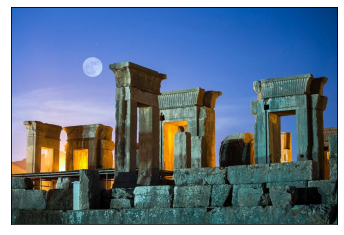

In [2]:
def show_image(img, title='', save=False, name=''):
    '''
    a function for showing images
    '''
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    if save:
        iio.imwrite(name, img)
    plt.show()
    
def scale(img):
    return np.uint8((img-np.min(img))/(np.max(img)-np.min(img))*255)
    
img = iio.imread('Q3.jpg')
show_image(img)

## Adding Noise

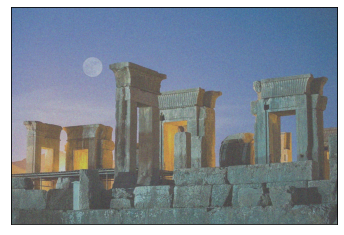

In [3]:
sigma = 30
img = np.array(img, dtype='float64')
nimg = img + np.random.normal(0, sigma, size=img.shape)
show_image(scale(nimg), save=True, name='noisy_image.jpg')

## Wavelet with Haar Filter

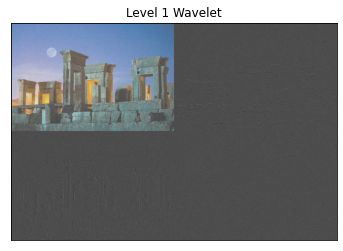

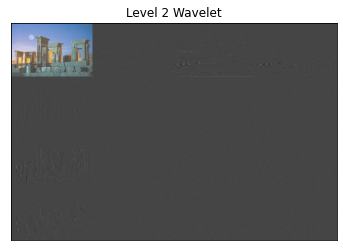

In [4]:
def haar_wavelet(img):
    img = img.copy()
    out = np.zeros((int(2*np.ceil(img.shape[0]/2)), int(2*np.ceil(img.shape[1]/2)), img.shape[2]))
    for i in range(img.shape[2]):
        img1 = img[:,:,i].astype(np.float64)
        coeffs = pywt.dwt2(img1, 'haar')
        LL, (LH, HL, HH) = coeffs
        out[:out.shape[0]//2, :out.shape[1]//2, i] = LL
        out[:out.shape[0]//2, out.shape[1]//2:, i] = LH
        out[out.shape[0]//2:, :out.shape[1]//2, i] = HL
        out[out.shape[0]//2:, out.shape[1]//2:, i] = HH
    return out

def reverse_haar_wavelet(img):
    out = np.zeros(img.shape)
    for i in range(img.shape[2]):
        LL = img[:img.shape[0]//2, :img.shape[1]//2, i].astype('float64')
        LH = img[:img.shape[0]//2, img.shape[1]//2:, i].astype('float64')
        HL = img[img.shape[0]//2:, :img.shape[1]//2, i].astype('float64')
        HH = img[img.shape[0]//2:, img.shape[1]//2:, i].astype('float64')
        out[:,:,i] = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
    return out
            
level1 = haar_wavelet(nimg)
level2 = haar_wavelet(level1)
show_image(scale(level1), title='Level 1 Wavelet', save=True, name='level1_wavelet.jpg')
show_image(scale(level2), title='Level 2 Wavelet', save=True, name='level2_wavelet.jpg')

## Hard And Soft Thresholds

In [5]:
def hard_thresh(x, t):
    x = x.copy()
    x[np.abs(x)<t] = 0
    return x

def soft_thresh(x, t):
    y = np.abs(x) - t
    y[y<=0] = 0
    return y*np.sign(x)

## VisoShrink 

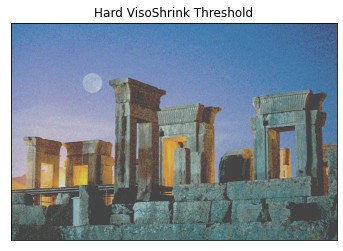

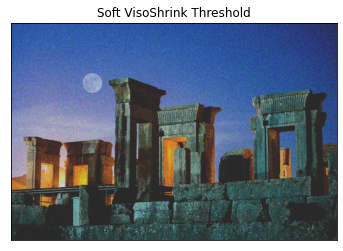

In [9]:
t = sigma*np.sqrt(2*np.log10(nimg.size))
hard_viso = hard_thresh(level1.astype('float64'), t)
hard_viso = hard_viso
hard_viso = reverse_haar_wavelet(hard_viso)
show_image(scale(hard_viso), title='Hard VisoShrink Threshold', save=True, name='hard_viso.jpg')

soft_viso = soft_thresh(level1.astype('float64'), t)
soft_viso = soft_viso
soft_viso = reverse_haar_wavelet(soft_viso)
show_image(scale(soft_viso), title='Soft VisoShrink Threshold', save=True, name='soft_viso.jpg')

## BayesShrink

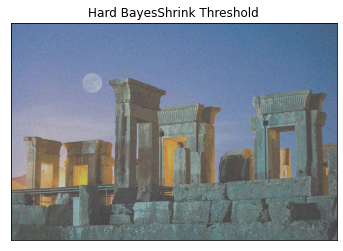

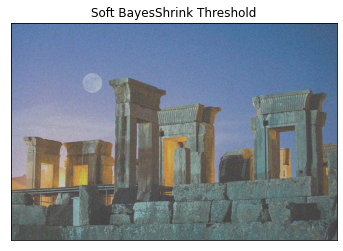

In [15]:
sigma_signal = np.sqrt(np.max([np.std(level1)**2-sigma**2, 0]))
t = 0
if sigma_signal > 0:
    t = sigma**2/sigma_signal
else:
    t = 1e10
    
hard_bayes = hard_thresh(level1.astype('float64'), t)
hard_bayes = hard_bayes
hard_bayes = reverse_haar_wavelet(hard_bayes)
show_image(scale(hard_bayes), title='Hard BayesShrink Threshold', save=True, name='hard_bayes.jpg')

soft_bayes = soft_thresh(level1.astype('float64'), t)
soft_bayes = soft_bayes
soft_bayes = reverse_haar_wavelet(soft_bayes)
show_image(scale(soft_bayes), title='Soft BayesShrink Threshold', save=True, name='soft_bayes.jpg')

## Effect of Threshold

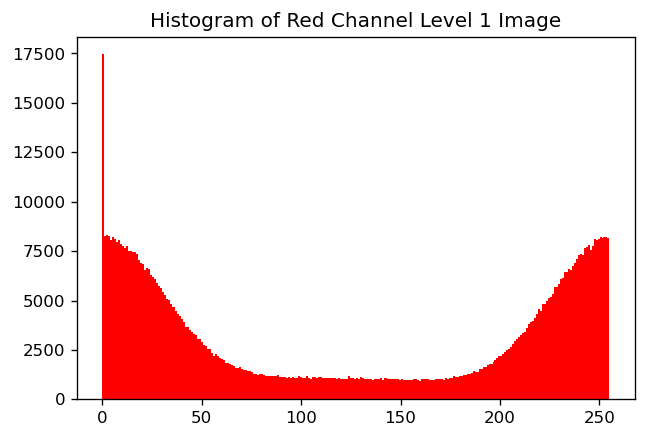

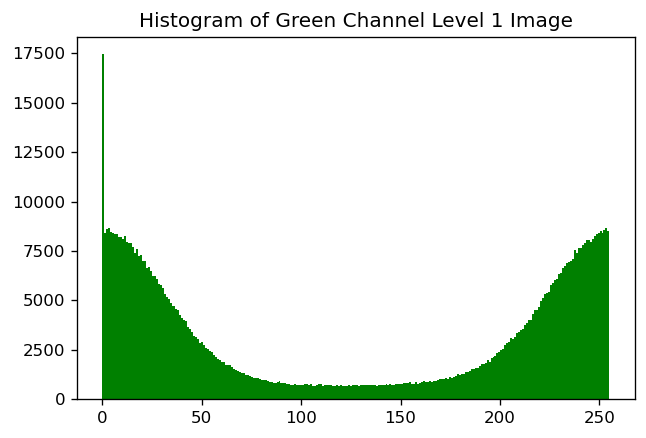

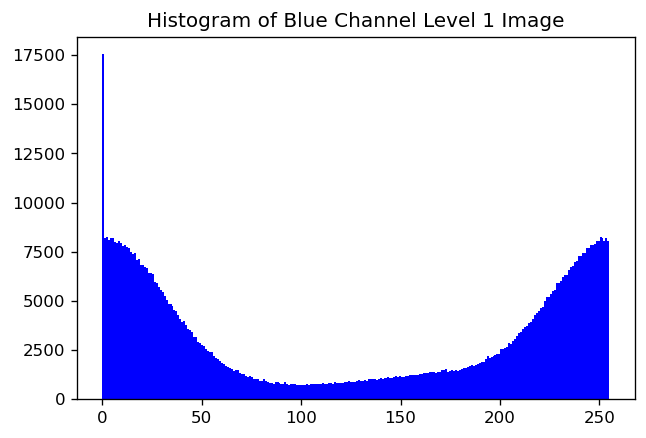

In [12]:
def hist(img, title='', name='', color='blue'):
    '''
    draw histogram of an image
    '''
    h = np.histogram(img.flatten(), bins=256)
    plt.figure(dpi=120)
    plt.hist(img.flatten(), bins=256, color=color)
    plt.title(title)
    plt.savefig(name)
    plt.show()
    return h

h1 = hist(np.uint8(level1[:,:,0]), title='Histogram of Red Channel Level 1 Image', name='hist_level1_red.jpg', color='red')
h2 = hist(np.uint8(level1[:,:,1]), title='Histogram of Green Channel Level 1 Image', name='hist_level1_green.jpg', color='green')
h3 = hist(np.uint8(level1[:,:,2]), title='Histogram of Blue Channel Level 1 Image', name='hist_level1_blue.jpg', color='blue')